## Topic: Agricultural commodity Prices Prediction.

---
---
### Team Number : 14




*1.   Sai Kiran Mohanty  --> 2341013236*

*2.  Aditya Kumar Das   --> 2341004026*

*3.  Chidananda Sahoo  --> 2341019123*

---
---
##  Part B : Model Training and Comparision.

---
---


In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from tensorflow import keras
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error, r2_score , mean_absolute_error

In [31]:
# Load data
df = pd.read_csv("/content/drive/MyDrive/CropComodity_PricePrediction/Unprocessed_Data/Price_Agriculture_commodities_Week.csv")

print("="*80)
print("STEP 1: DATA LOADING & INITIAL CLEANING")
print("="*80)
print(f"Dataset shape: {df.shape}")
print(f"\nMissing values:\n{df.isnull().sum()}")

STEP 1: DATA LOADING & INITIAL CLEANING
Dataset shape: (23093, 10)

Missing values:
State           0
District        0
Market          0
Commodity       0
Variety         0
Grade           0
Arrival_Date    0
Min Price       0
Max Price       0
Modal Price     0
dtype: int64


In [32]:
# Drop coloumns that are not required.
df = df.drop(['Variety','Min Price', 'Max Price'], axis=1)

In [33]:
# IMPORTANT: Save original text values BEFORE encoding
print("\n[CRITICAL] Saving original categorical values before encoding...")
df_original = df.copy()  # Keep a copy with text names

# Create mapping dictionaries from original data
state_name_to_code = {}
district_name_to_code = {}
market_name_to_code = {}
commodity_name_to_code = {}
grade_name_to_code = {}

print("\n" + "="*80)
print("STEP 2: ENCODING CATEGORICAL FEATURES")
print("="*80)

# Encode each column and save mappings
label_encoders = {}
categorical_cols = ['State', 'District', 'Market', 'Commodity', 'Grade']

for col in categorical_cols:
    le = LabelEncoder()
    df[col + '_Encoded'] = le.fit_transform(df[col])
    label_encoders[col] = le

    # Create name-to-code mapping
    mapping_dict = dict(zip(df[col], df[col + '_Encoded']))

    if col == 'State':
        state_name_to_code = mapping_dict
    elif col == 'District':
        district_name_to_code = mapping_dict
    elif col == 'Market':
        market_name_to_code = mapping_dict
    elif col == 'Commodity':
        commodity_name_to_code = mapping_dict
    elif col == 'Grade':
        grade_name_to_code = mapping_dict

    print(f"✓ Encoded {col}: {len(mapping_dict)} unique values")

# Drop original text columns, keep encoded versions
df = df.drop(categorical_cols, axis=1)

# Rename encoded columns to original names for easier use
df = df.rename(columns={
    'State_Encoded': 'State',
    'District_Encoded': 'District',
    'Market_Encoded': 'Market',
    'Commodity_Encoded': 'Commodity',
    'Grade_Encoded': 'Grade'
})


[CRITICAL] Saving original categorical values before encoding...

STEP 2: ENCODING CATEGORICAL FEATURES
✓ Encoded State: 27 unique values
✓ Encoded District: 403 unique values
✓ Encoded Market: 1289 unique values
✓ Encoded Commodity: 234 unique values
✓ Encoded Grade: 4 unique values


In [34]:
# Convert date
df['Arrival_Date'] = pd.to_datetime(df['Arrival_Date'], format='%d-%m-%Y')
df = df.sort_values(['Commodity', 'Market', 'Arrival_Date']).reset_index(drop=True)

In [35]:
print("\n" + "="*80)
print("STEP 3: FEATURE ENGINEERING")
print("="*80)

# Temporal features
print("[1/5] Extracting temporal features...")
df['Year'] = df['Arrival_Date'].dt.year
df['Month'] = df['Arrival_Date'].dt.month
df['Day'] = df['Arrival_Date'].dt.day
df['DayOfWeek'] = df['Arrival_Date'].dt.dayofweek
df['Quarter'] = df['Arrival_Date'].dt.quarter
df['DayOfYear'] = df['Arrival_Date'].dt.dayofyear

# Cyclical encoding
df['Month_Sin'] = np.sin(2 * np.pi * df['Month'] / 12)
df['Month_Cos'] = np.cos(2 * np.pi * df['Month'] / 12)

# Lag features
print("[2/5] Creating lag features...")
for lag in [1, 3, 7, 14, 30]:
    df[f'Price_Lag_{lag}'] = df.groupby(['Commodity', 'Market'])['Modal Price'].shift(lag)

# Rolling statistics
print("[3/5] Computing rolling statistics...")
for window in [7, 14, 30]:
    df[f'Price_MA_{window}'] = df.groupby(['Commodity', 'Market'])['Modal Price'].transform(
        lambda x: x.rolling(window=window, min_periods=1).mean()
    )
    df[f'Price_Std_{window}'] = df.groupby(['Commodity', 'Market'])['Modal Price'].transform(
        lambda x: x.rolling(window=window, min_periods=1).std()
    )

# Price change features
print("[4/5] Computing price changes...")
df['Price_Change'] = df.groupby(['Commodity', 'Market'])['Modal Price'].diff()
df['Price_Change_Pct'] = df.groupby(['Commodity', 'Market'])['Modal Price'].pct_change()

# Fill NaN values
df = df.fillna(method='bfill').fillna(method='ffill').fillna(0)

print("[5/5] Feature engineering complete!")



STEP 3: FEATURE ENGINEERING
[1/5] Extracting temporal features...
[2/5] Creating lag features...
[3/5] Computing rolling statistics...
[4/5] Computing price changes...
[5/5] Feature engineering complete!


In [36]:
# Select features
feature_cols = [
    'State', 'District', 'Market', 'Commodity', 'Grade',
    'Month', 'DayOfWeek', 'Quarter', 'Month_Sin', 'Month_Cos',
    'Price_Lag_1', 'Price_Lag_3', 'Price_Lag_7', 'Price_Lag_14', 'Price_Lag_30',
    'Price_MA_7', 'Price_MA_14', 'Price_MA_30',
    'Price_Std_7', 'Price_Std_14', 'Price_Std_30',
    'Price_Change', 'Price_Change_Pct'
]

target_col = 'Modal Price'

print(f"\n✓ Total features: {len(feature_cols)}")
print(f"✓ Dataset shape: {df.shape}")

# Display available options for users
print("\n" + "="*80)
print("AVAILABLE OPTIONS FOR PREDICTION")
print("="*80)
print(f"\nStates: {sorted(state_name_to_code.keys())[:10]}...")
print(f"Total states: {len(state_name_to_code)}")
print(f"\nCommodities: {sorted(commodity_name_to_code.keys())[:10]}...")
print(f"Total commodities: {len(commodity_name_to_code)}")
print(f"\nGrades: {sorted(grade_name_to_code.keys())}")


✓ Total features: 23
✓ Dataset shape: (23093, 28)

AVAILABLE OPTIONS FOR PREDICTION

States: ['Andaman and Nicobar', 'Andhra Pradesh', 'Bihar', 'Chandigarh', 'Chattisgarh', 'Goa', 'Gujarat', 'Haryana', 'Himachal Pradesh', 'Jammu and Kashmir']...
Total states: 27

Commodities: ['Ajwan', 'Alasande Gram', 'Almond(Badam)', 'Alsandikai', 'Amaranthus', 'Amla(Nelli Kai)', 'Amphophalus', 'Anthorium', 'Apple', 'Arecanut(Betelnut/Supari)']...
Total commodities: 234

Grades: ['FAQ', 'Large', 'Medium', 'Small']


In [37]:
print("\n" + "="*80)
print("STEP 4: PREPARING TIME SERIES SEQUENCES")
print("="*80)

X = df[feature_cols].values
y = df[target_col].values

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

TIME_STEPS = 5

def create_sequences(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(X_scaled, y_scaled, TIME_STEPS)

split_idx = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]

print(f"✓ Sequence shape: {X_seq.shape}")
print(f"✓ Training samples: {len(X_train)}")
print(f"✓ Testing samples: {len(X_test)}")


STEP 4: PREPARING TIME SERIES SEQUENCES
✓ Sequence shape: (23088, 5, 23)
✓ Training samples: 18470
✓ Testing samples: 4618


In [38]:



print("\n" + "="*80)
print("STEP 5: TRAINING LSTM MODEL")
print("="*80)

lstm_model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(TIME_STEPS, X_train.shape[2])),
    Dropout(0.2),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)

history_lstm = lstm_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Evaluate
y_pred_lstm_scaled = lstm_model.predict(X_test, verbose=0)
y_pred_lstm = scaler_y.inverse_transform(y_pred_lstm_scaled)
y_test_actual = scaler_y.inverse_transform(y_test)

rmse_lstm = np.sqrt(mean_squared_error(y_test_actual, y_pred_lstm))
mae_lstm = mean_squared_error(y_test_actual, y_pred_lstm)
r2_lstm = r2_score(y_test_actual, y_pred_lstm)

print(f"\n{'='*80}")
print("LSTM MODEL RESULTS")
print(f"{'='*80}")
print(f"RMSE: {rmse_lstm:.6f}")
print(f"MAE: {mae_lstm:.6f}")
print(f"R² Score: {r2_lstm:.6f}")

# Find a valid combination to test
print("\n" + "="*80)
print("FINDING VALID TEST COMBINATIONS")
print("="*80)

valid_combos = df.groupby(['Commodity', 'Market']).size()
valid_combos = valid_combos[valid_combos >= TIME_STEPS].sort_values(ascending=False)

print(f"✓ Found {len(valid_combos)} valid commodity-market combinations")
print(f"\nTop 5 combinations with most data:")

for i, ((commodity_code, market_code), count) in enumerate(valid_combos.head(5).items(), 1):
    # Find original names
    commodity_name = [k for k, v in commodity_name_to_code.items() if v == commodity_code][0]
    market_name = [k for k, v in market_name_to_code.items() if v == market_code][0]

    # Get state and district for this combo
    sample = df[(df['Commodity'] == commodity_code) & (df['Market'] == market_code)].iloc[0]
    state_code = sample['State']
    district_code = sample['District']
    grade_code = sample['Grade']

    state_name = [k for k, v in state_name_to_code.items() if v == state_code][0]
    district_name = [k for k, v in district_name_to_code.items() if v == district_code][0]
    grade_name = [k for k, v in grade_name_to_code.items() if v == grade_code][0]

    print(f"\n{i}. {commodity_name} in {market_name} ({count} records)")
    print(f"   State: {state_name}, District: {district_name}, Grade: {grade_name}")

# Test with a valid combination
print("\n" + "="*80)
print("RUNNING TEST PREDICTION")
print("="*80)

# Get details of the best combination
best_commodity_code, best_market_code = valid_combos.index[0]
best_sample = df[(df['Commodity'] == best_commodity_code) &
                 (df['Market'] == best_market_code)].iloc[-1]

# Find original names
test_state = [k for k, v in state_name_to_code.items() if v == best_sample['State']][0]
test_district = [k for k, v in district_name_to_code.items() if v == best_sample['District']][0]
test_market = [k for k, v in market_name_to_code.items() if v == best_market_code][0]
test_commodity = [k for k, v in commodity_name_to_code.items() if v == best_commodity_code][0]
test_grade = [k for k, v in grade_name_to_code.items() if v == best_sample['Grade']][0]

print(f"\nTesting with: {test_commodity} in {test_market}, {test_state}")

result = test_model_with_user_input(
    state_name=test_state,
    district_name=test_district,
    market_name=test_market,
    commodity_name=test_commodity,
    grade_name=test_grade,
    prediction_date='2022-08-01'
)

print("\n" + "="*80)



STEP 5: TRAINING LSTM MODEL
Epoch 1/100
462/462 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - loss: 6.0826e-04 - mae: 0.0124 - val_loss: 2.0431e-04 - val_mae: 0.0074 - learning_rate: 0.0010
Epoch 2/100
462/462 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 4.3862e-04 - mae: 0.0097 - val_loss: 2.5167e-04 - val_mae: 0.0092 - learning_rate: 0.0010
Epoch 3/100
462/462 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 4.0469e-04 - mae: 0.0099 - val_loss: 2.0185e-04 - val_mae: 0.0074 - learning_rate: 0.0010
Epoch 4/100
462/462 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 4.3332e-04 - mae: 0.0097 - val_loss: 1.4882e-04 - val_mae: 0.0070 - learning_rate: 0.0010
Epoch 5/100
462/462 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 3.6241e-04 - mae: 0.0089 - val_loss: 1.3844e-04 - val_mae: 0.0062 - learning_rate: 0.0010
Epoch 6/100
462/462 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 5.2208e-04 - mae: 0.0091 - val_loss: 1.2968e-04 - val_mae: 0.0062 - learning_rate: 0.0010
Epoch 7/100
462/462 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - l

In [39]:
 result = test_model_with_user_input(
       state_name='Gujarat',
       district_name='Amreli',
       market_name='Damnagar',
       commodity_name='Cauliflower',
       grade_name='FAQ',
       prediction_date='2022-08-01'
   )


TESTING LSTM MODEL
✓ Converted inputs to codes:
   Gujarat → 6
   Amreli → 12
   Damnagar → 309
   Cauliflower → 40
   FAQ → 0

📊 User Inputs:
   State: Gujarat
   District: Amreli
   Market: Damnagar
   Commodity: Cauliflower
   Grade: FAQ
   Date: 2022-08-01

🎯 Predicted Modal Price: ₹6072.1641

📈 Recent Historical Prices (last 5 days):
   Day -5: ₹6850.0000
   Day -4: ₹6250.0000
   Day -3: ₹7350.0000
   Day -2: ₹5000.0000
   Day -1: ₹4350.0000

✓ Prediction completed successfully!


In [40]:
y_pred_lstm_scaled = lstm_model.predict(X_test, verbose=0)
y_pred_lstm = scaler_y.inverse_transform(y_pred_lstm_scaled)
y_test_actual = scaler_y.inverse_transform(y_test)

rmse_lstm = np.sqrt(mean_squared_error(y_test_actual, y_pred_lstm))
mae_lstm = mean_absolute_error(y_test_actual, y_pred_lstm)
r2_lstm = r2_score(y_test_actual, y_pred_lstm)

print(f"\n✓ LSTM RESULTS:")
print(f"  RMSE: {rmse_lstm:.6f}")
print(f"  MAE:  {mae_lstm:.6f}")
print(f"  R²:   {r2_lstm:.6f}")


✓ LSTM RESULTS:
  RMSE: 2237.765357
  MAE:  1145.725940
  R²:   0.611555


In [41]:

print("\n" + "="*80)
print("TRAINING MODEL 2: GRU")
print("="*80)

gru_model = Sequential([
    GRU(128, return_sequences=True, input_shape=(TIME_STEPS, X_train.shape[2])),
    Dropout(0.3),
    GRU(64, return_sequences=True),
    Dropout(0.3),
    GRU(32),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)
])

gru_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                  loss='mse', metrics=['mae'])

history_gru = gru_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

y_pred_gru_scaled = gru_model.predict(X_test, verbose=0)
y_pred_gru = scaler_y.inverse_transform(y_pred_gru_scaled)

rmse_gru = np.sqrt(mean_squared_error(y_test_actual, y_pred_gru))
mae_gru = mean_absolute_error(y_test_actual, y_pred_gru)
r2_gru = r2_score(y_test_actual, y_pred_gru)

print(f"\n✓ GRU RESULTS:")
print(f"  RMSE: {rmse_gru:.6f}")
print(f"  MAE:  {mae_gru:.6f}")
print(f"  R²:   {r2_gru:.6f}")



TRAINING MODEL 2: GRU
Epoch 1/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - loss: 0.0016 - mae: 0.0228 - val_loss: 2.5838e-04 - val_mae: 0.0091 - learning_rate: 0.0010
Epoch 2/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 7.1430e-04 - mae: 0.0123 - val_loss: 1.9594e-04 - val_mae: 0.0093 - learning_rate: 0.0010
Epoch 3/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 4.6141e-04 - mae: 0.0109 - val_loss: 2.0835e-04 - val_mae: 0.0107 - learning_rate: 0.0010
Epoch 4/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 4.7261e-04 - mae: 0.0105 - val_loss: 1.8202e-04 - val_mae: 0.0088 - learning_rate: 0.0010
Epoch 5/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 5.0663e-04 - mae: 0.0099 - val_loss: 1.7912e-04 - val_mae: 0.0087 - learning_rate: 0.0010
Epoch 6/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 4.4972e-04 - mae: 0.0098 - val_loss: 1.8230e-04 - val_mae: 0.0080 - learning_rate: 0.0010
Epoch 7/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 3.5780

In [42]:
print("\n" + "="*80)
print("TRAINING MODEL 3: TRANSFORMER")
print("="*80)

def build_transformer(input_shape, head_size=64, num_heads=4, ff_dim=128, num_blocks=2):
    inputs = keras.Input(shape=input_shape)
    x = inputs

    for _ in range(num_blocks):
        # Multi-head attention
        attn = MultiHeadAttention(num_heads=num_heads, key_dim=head_size, dropout=0.1)(x, x)
        x = LayerNormalization(epsilon=1e-6)(x + attn)

        # Feed-forward
        ff = Dense(ff_dim, activation='relu')(x)
        ff = Dropout(0.1)(ff)
        ff = Dense(input_shape[-1])(ff)
        x = LayerNormalization(epsilon=1e-6)(x + ff)

    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(1)(x)

    return keras.Model(inputs=inputs, outputs=outputs)

transformer_model = build_transformer((TIME_STEPS, X_train.shape[2]))
transformer_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                          loss='mse', metrics=['mae'])

history_transformer = transformer_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

y_pred_transformer_scaled = transformer_model.predict(X_test, verbose=0)
y_pred_transformer = scaler_y.inverse_transform(y_pred_transformer_scaled)

rmse_transformer = np.sqrt(mean_squared_error(y_test_actual, y_pred_transformer))
mae_transformer = mean_absolute_error(y_test_actual, y_pred_transformer)
r2_transformer = r2_score(y_test_actual, y_pred_transformer)

print(f"\n✓ TRANSFORMER RESULTS:")
print(f"  RMSE: {rmse_transformer:.6f}")
print(f"  MAE:  {mae_transformer:.6f}")
print(f"  R²:   {r2_transformer:.6f}")


TRAINING MODEL 3: TRANSFORMER
Epoch 1/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - loss: 0.0712 - mae: 0.1605 - val_loss: 2.7575e-04 - val_mae: 0.0100 - learning_rate: 0.0010
Epoch 2/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.0024 - mae: 0.0271 - val_loss: 3.1413e-04 - val_mae: 0.0133 - learning_rate: 0.0010
Epoch 3/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 0.0012 - mae: 0.0190 - val_loss: 3.3399e-04 - val_mae: 0.0141 - learning_rate: 0.0010
Epoch 4/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - loss: 0.0011 - mae: 0.0172 - val_loss: 3.3010e-04 - val_mae: 0.0140 - learning_rate: 0.0010
Epoch 5/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 0.0014 - mae: 0.0169 - val_loss: 3.3238e-04 - val_mae: 0.0141 - learning_rate: 0.0010
Epoch 6/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 9.5550e-04 - mae: 0.0156 - val_loss: 3.4652e-04 - val_mae: 0.0146 - learning_rate: 0.0010
Epoch 7/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 8.5223e-04 - m

In [43]:
def test_any_model(model, model_name, state_name, district_name, market_name,
                   commodity_name, grade_name, prediction_date):
    """
    Test ANY model (LSTM/GRU/Transformer) with user inputs
    """
    print("\n" + "="*70)
    print(f"TESTING {model_name} MODEL")
    print("="*70)

    # Convert text names to codes
    try:
        state_code = state_name_to_code[state_name]
        district_code = district_name_to_code[district_name]
        market_code = market_name_to_code[market_name]
        commodity_code = commodity_name_to_code[commodity_name]
        grade_code = grade_name_to_code[grade_name]
    except KeyError as e:
        print(f"❌ Error: '{e.args[0]}' not found")
        return None

    # Get historical data
    hist_data = df[
        (df['Commodity'] == commodity_code) &
        (df['Market'] == market_code)
    ].tail(TIME_STEPS)

    if len(hist_data) < TIME_STEPS:
        print(f"❌ Need {TIME_STEPS} days of history, found {len(hist_data)}")
        return None

    # Prepare input
    X_input = hist_data[feature_cols].values
    X_scaled = scaler_X.transform(X_input)
    X_seq = X_scaled.reshape(1, TIME_STEPS, -1)

    # Predict with the specified model
    y_pred_scaled = model.predict(X_seq, verbose=0)
    predicted_price = scaler_y.inverse_transform(y_pred_scaled)[0][0]

    # Display results
    print(f"\nInputs: {state_name} | {district_name} | {market_name}")
    print(f"   Commodity: {commodity_name} | Grade: {grade_name}")
    print(f"\n {model_name} Predicted Price: ₹{predicted_price:.4f}")

    recent_prices = hist_data['Modal Price'].tail(3).values
    print(f"\nRecent Prices: {recent_prices}")

    return predicted_price


# Now test all three models with the same inputs!
print("\n" + "="*80)
print("COMPARING ALL THREE MODELS")
print("="*80)

test_inputs = {
    'state_name': "Gujarat",
    'district_name': "Amreli",
    'market_name': "Damnagar",
    'commodity_name': "Brinjal",
    'grade_name': "FAQ",
    'prediction_date': '2022-08-01'
}

# Test LSTM
result_lstm = test_any_model(lstm_model, "LSTM", **test_inputs)

# Test GRU
result_gru = test_any_model(gru_model, "GRU", **test_inputs)

# Test Transformer
result_transformer = test_any_model(transformer_model, "TRANSFORMER", **test_inputs)

# Compare results
print("\n" + "="*70)
print("PREDICTION COMPARISON")
print("="*70)
print(f"LSTM:        ₹{result_lstm:.4f}")
print(f"GRU:         ₹{result_gru:.4f}")
print(f"Transformer: ₹{result_transformer:.4f}")


COMPARING ALL THREE MODELS

TESTING LSTM MODEL

Inputs: Gujarat | Amreli | Damnagar
   Commodity: Brinjal | Grade: FAQ

 LSTM Predicted Price: ₹3016.8325

Recent Prices: [3850. 3200. 3750.]

TESTING GRU MODEL

Inputs: Gujarat | Amreli | Damnagar
   Commodity: Brinjal | Grade: FAQ

 GRU Predicted Price: ₹3250.8474

Recent Prices: [3850. 3200. 3750.]

TESTING TRANSFORMER MODEL

Inputs: Gujarat | Amreli | Damnagar
   Commodity: Brinjal | Grade: FAQ

 TRANSFORMER Predicted Price: ₹3617.0073

Recent Prices: [3850. 3200. 3750.]

PREDICTION COMPARISON
LSTM:        ₹3016.8325
GRU:         ₹3250.8474
Transformer: ₹3617.0073


In [44]:
"""
===============================================================================
STEP 5: MODEL COMPARISON & EVALUATION
===============================================================================
"""

print("\n" + "="*80)
print("MODEL COMPARISON SUMMARY")
print("="*80)

comparison_df = pd.DataFrame({
    'Model': ['LSTM', 'GRU', 'Transformer'],
    'RMSE': [rmse_lstm, rmse_gru, rmse_transformer],
    'MAE': [mae_lstm, mae_gru, mae_transformer],
    'R² Score': [r2_lstm, r2_gru, r2_transformer],
    'Training Time': [
        len(history_lstm.history['loss']),
        len(history_gru.history['loss']),
        len(history_transformer.history['loss'])
    ]
})

print("\n" + comparison_df.to_string(index=False))

best_model_idx = comparison_df['R² Score'].idxmax()
best_model = comparison_df.loc[best_model_idx, 'Model']
best_r2 = comparison_df.loc[best_model_idx, 'R² Score']

print(f"\n{'='*80}")
print(f"🏆 BEST MODEL: {best_model}")
print(f"   R² Score: {best_r2:.6f}")
print(f"   RMSE: {comparison_df.loc[best_model_idx, 'RMSE']:.6f}")
print(f"   MAE: {comparison_df.loc[best_model_idx, 'MAE']:.6f}")
print(f"{'='*80}")



MODEL COMPARISON SUMMARY

      Model        RMSE         MAE  R² Score  Training Time
       LSTM 2237.765357 1145.725940  0.611555             49
        GRU 2308.253224 1336.952297  0.586698             47
Transformer 3042.517213 2251.765834  0.281930             53

🏆 BEST MODEL: LSTM
   R² Score: 0.611555
   RMSE: 2237.765357
   MAE: 1145.725940



[Generating visualizations...]
✓ Saved: model_comparison.png
✓ Saved: prediction_accuracy.png


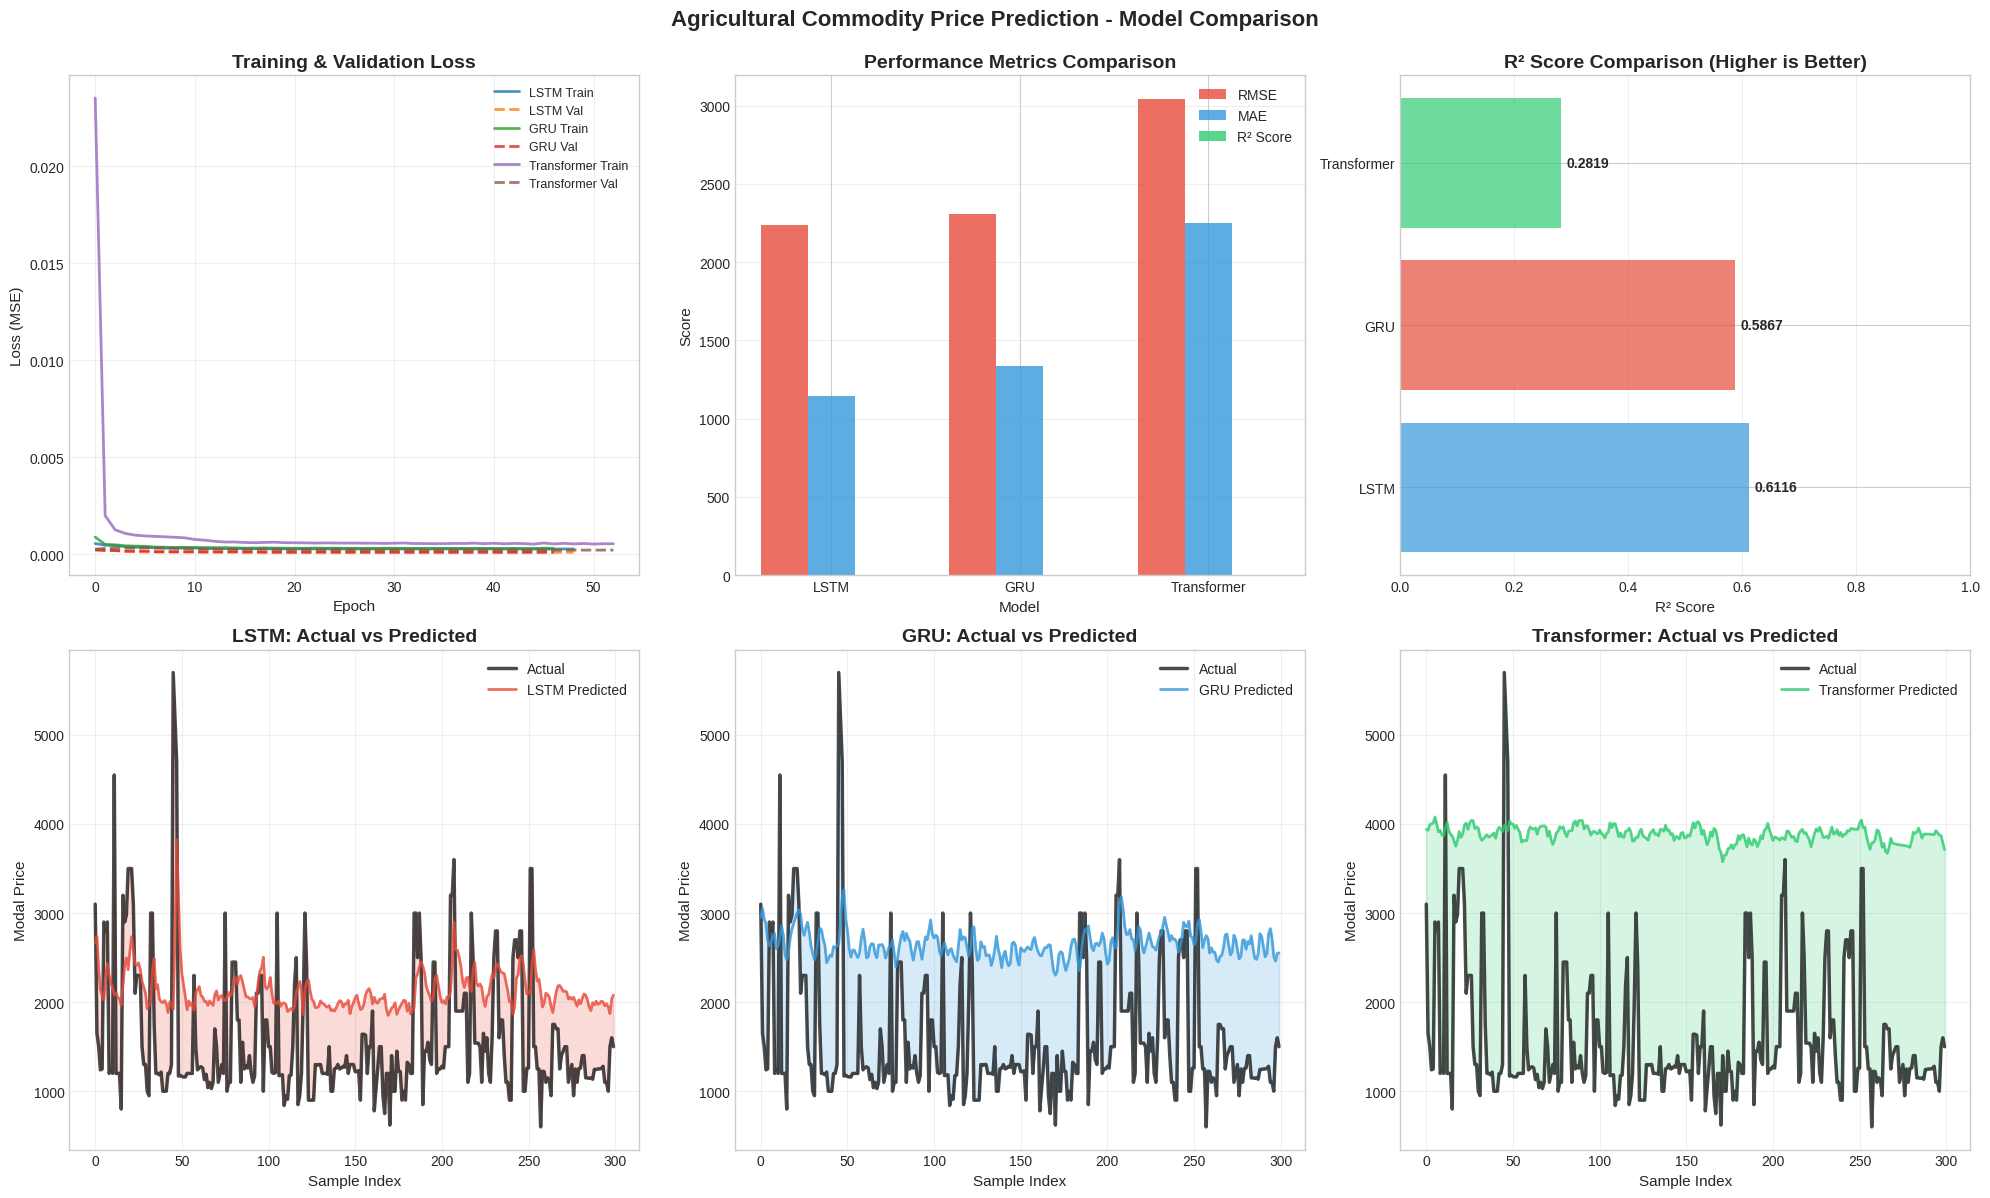

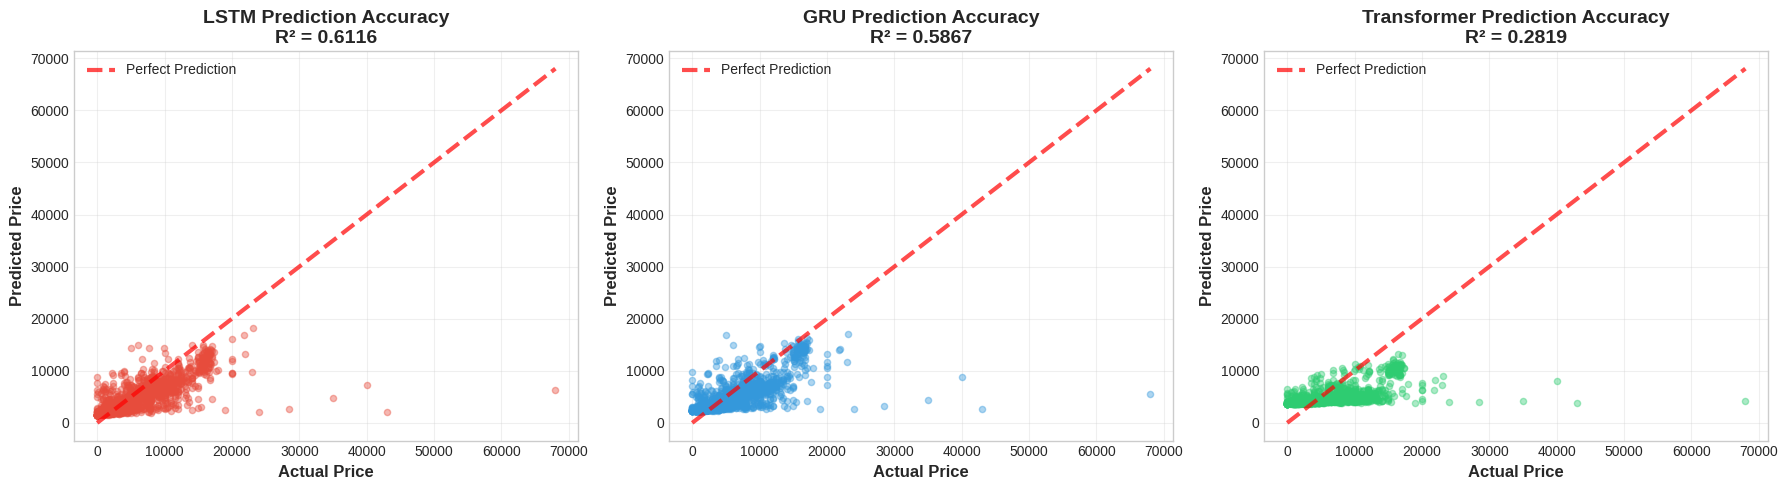


✓ ANALYSIS COMPLETE!

Visualizations saved:
   • model_comparison.png
   • prediction_accuracy.png

Best Model: LSTM (R² = 0.6116)


In [45]:
"""
===============================================================================
STEP 6: VISUALIZATIONS
===============================================================================
"""

print("\n[Generating visualizations...]")

plt.style.use('seaborn-v0_8-whitegrid')
fig = plt.figure(figsize=(20, 12))

# 1. Training Loss Comparison
ax1 = plt.subplot(2, 3, 1)
plt.plot(history_lstm.history['loss'], label='LSTM Train', linewidth=2, alpha=0.8)
plt.plot(history_lstm.history['val_loss'], label='LSTM Val', linewidth=2, alpha=0.8, linestyle='--')
plt.plot(history_gru.history['loss'], label='GRU Train', linewidth=2, alpha=0.8)
plt.plot(history_gru.history['val_loss'], label='GRU Val', linewidth=2, alpha=0.8, linestyle='--')
plt.plot(history_transformer.history['loss'], label='Transformer Train', linewidth=2, alpha=0.8)
plt.plot(history_transformer.history['val_loss'], label='Transformer Val', linewidth=2, alpha=0.8, linestyle='--')
plt.title('Training & Validation Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=11)
plt.ylabel('Loss (MSE)', fontsize=11)
plt.legend(fontsize=9)
plt.grid(True, alpha=0.3)

# 2. Metrics Bar Chart
ax2 = plt.subplot(2, 3, 2)
x_pos = np.arange(len(comparison_df))
width = 0.25
plt.bar(x_pos - width, comparison_df['RMSE'], width, label='RMSE', alpha=0.8, color='#e74c3c')
plt.bar(x_pos, comparison_df['MAE'], width, label='MAE', alpha=0.8, color='#3498db')
plt.bar(x_pos + width, comparison_df['R² Score'], width, label='R² Score', alpha=0.8, color='#2ecc71')
plt.xlabel('Model', fontsize=11)
plt.ylabel('Score', fontsize=11)
plt.title('Performance Metrics Comparison', fontsize=14, fontweight='bold')
plt.xticks(x_pos, comparison_df['Model'])
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3, axis='y')

# 3. R² Score Comparison
ax3 = plt.subplot(2, 3, 3)
colors = ['#3498db', '#e74c3c', '#2ecc71']
bars = plt.barh(comparison_df['Model'], comparison_df['R² Score'], color=colors, alpha=0.7)
plt.xlabel('R² Score', fontsize=11)
plt.title('R² Score Comparison (Higher is Better)', fontsize=14, fontweight='bold')
plt.xlim(0, 1)
for i, (bar, v) in enumerate(zip(bars, comparison_df['R² Score'])):
    plt.text(v + 0.01, i, f'{v:.4f}', va='center', fontsize=10, fontweight='bold')
plt.grid(True, alpha=0.3, axis='x')

# 4-6. Actual vs Predicted
sample_size = min(300, len(y_test_actual))
predictions = [y_pred_lstm, y_pred_gru, y_pred_transformer]
titles = ['LSTM', 'GRU', 'Transformer']
colors_pred = ['#e74c3c', '#3498db', '#2ecc71']

for idx, (pred, title, color) in enumerate(zip(predictions, titles, colors_pred)):
    ax = plt.subplot(2, 3, 4 + idx)
    plt.plot(y_test_actual[:sample_size], label='Actual', linewidth=2.5, alpha=0.7, color='black')
    plt.plot(pred[:sample_size], label=f'{title} Predicted', linewidth=2, alpha=0.8, color=color)
    plt.fill_between(range(sample_size),
                     y_test_actual[:sample_size].flatten(),
                     pred[:sample_size].flatten(),
                     alpha=0.2, color=color)
    plt.title(f'{title}: Actual vs Predicted', fontsize=14, fontweight='bold')
    plt.xlabel('Sample Index', fontsize=11)
    plt.ylabel('Modal Price', fontsize=11)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)

plt.suptitle('Agricultural Commodity Price Prediction - Model Comparison',
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
print("✓ Saved: model_comparison.png")

# Scatter plots (Prediction Accuracy)
fig2, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (ax, pred, name, r2, color) in enumerate(zip(axes, predictions, titles,
                                                        [r2_lstm, r2_gru, r2_transformer],
                                                        colors_pred)):
    ax.scatter(y_test_actual, pred, alpha=0.4, s=20, color=color)
    min_val, max_val = y_test_actual.min(), y_test_actual.max()
    ax.plot([min_val, max_val], [min_val, max_val],
            'r--', lw=3, label='Perfect Prediction', alpha=0.7)
    ax.set_xlabel('Actual Price', fontsize=12, fontweight='bold')
    ax.set_ylabel('Predicted Price', fontsize=12, fontweight='bold')
    ax.set_title(f'{name} Prediction Accuracy\nR² = {r2:.4f}',
                 fontsize=14, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('prediction_accuracy.png', dpi=300, bbox_inches='tight')
print("✓ Saved: prediction_accuracy.png")

plt.show()

print("\n" + "="*80)
print("✓ ANALYSIS COMPLETE!")
print("="*80)
print(f"\nVisualizations saved:")
print(f"   • model_comparison.png")
print(f"   • prediction_accuracy.png")
print(f"\nBest Model: {best_model} (R² = {best_r2:.4f})")


In [46]:
# Save models
print(f"\nSaving trained models...")
lstm_model.save('lstm_model.h5')
gru_model.save('gru_model.h5',)
transformer_model.save('transformer_model.h5')
print(f"Models saved: lstm_model.h5, gru_model.h5, transformer_model.h5")

# Save comparison results
comparison_df.to_csv('model_comparison_results.csv', index=False)
print(f"✓ Results saved: model_comparison_results.csv")


Saving trained models...
Models saved: lstm_model.h5, gru_model.h5, transformer_model.h5
✓ Results saved: model_comparison_results.csv
